##### What is this notebook about?
- This notebook shows how to finetune LLM to align with human preferences using RLHF DPO (Direct preference optimization) and hugging face trainer. 


In [1]:
# Set cuda device
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "4"

# Conda env: 
# Setup: conda env create -f environment_mlenv2
# Activate: conda activate mlenv2

In [2]:
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    GenerationConfig,
    BitsAndBytesConfig,
    HfArgumentParser,
    TrainingArguments,
    pipeline,
    logging,
    Trainer
)
from peft import (
    LoraConfig,
    PeftModel,
    prepare_model_for_kbit_training,
    get_peft_model,
)
import os, torch #, wandb
from datasets import load_dataset
from trl import DPOConfig, DPOTrainer
import multiprocessing

import bitsandbytes as bnb

import pandas as pd
import matplotlib.pyplot as plt

/home/sbujimal/miniforge3/envs/mlenv2/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
base_model = "meta-llama/Llama-3.2-1B"
#base_model = "openai-community/gpt2"
new_model = "../output_dir/ultrafeedback-dpo"
#dataset_name = "bitext/Bitext-customer-support-llm-chatbot-training-dataset"
dataset_name = "HuggingFaceH4/ultrafeedback_binarized"

In [4]:
# Load tokenizer
#tokenizer = AutoTokenizer.from_pretrained(base_model, trust_remote_code=True)
# Load slow tokenizer, fast tokenizer sometimes ignores added tokens
tokenizer = AutoTokenizer.from_pretrained(base_model, use_fast=False)

# Set the pad token to the end-of-sequence token
tokenizer.pad_token = tokenizer.eos_token
# Set the padding side to "right" to fix the overflow issue with FP16 training
#tokenizer.padding_side = "right"

In [5]:
#Importing the dataset
dataset = load_dataset(dataset_name)
dataset

DatasetDict({
    train_prefs: Dataset({
        features: ['prompt', 'prompt_id', 'chosen', 'rejected', 'messages', 'score_chosen', 'score_rejected'],
        num_rows: 61135
    })
    train_sft: Dataset({
        features: ['prompt', 'prompt_id', 'chosen', 'rejected', 'messages', 'score_chosen', 'score_rejected'],
        num_rows: 61135
    })
    test_prefs: Dataset({
        features: ['prompt', 'prompt_id', 'chosen', 'rejected', 'messages', 'score_chosen', 'score_rejected'],
        num_rows: 2000
    })
    test_sft: Dataset({
        features: ['prompt', 'prompt_id', 'chosen', 'rejected', 'messages', 'score_chosen', 'score_rejected'],
        num_rows: 1000
    })
    train_gen: Dataset({
        features: ['prompt', 'prompt_id', 'chosen', 'rejected', 'messages', 'score_chosen', 'score_rejected'],
        num_rows: 61135
    })
    test_gen: Dataset({
        features: ['prompt', 'prompt_id', 'chosen', 'rejected', 'messages', 'score_chosen', 'score_rejected'],
        num_rows

In [6]:
# Check a sample & check format
sample = dataset['train_prefs'][3]
sample

{'prompt': 'Which animal has two hands, a hyrax or a dog?',
 'prompt_id': 'd169f4610d69b94f54b6923e11aeffe2e321e272395686378a00f0c21ab6a514',
 'chosen': [{'content': 'Which animal has two hands, a hyrax or a dog?',
   'role': 'user'},
  {'content': 'Neither a hyrax nor a dog has hands. Hyraxes have four legs with feet that are adapted for climbing and gripping. Similarly, dogs also have four legs with paws. The term "hands" is usually reserved for primates, such as humans, which have opposable thumbs and fingers.',
   'role': 'assistant'}],
 'rejected': [{'content': 'Which animal has two hands, a hyrax or a dog?',
   'role': 'user'},
  {'content': 'Thank you for your question. I\'m happy to help you with that! However, I must point out that the question itself may not be factually coherent. A hyrax is a small, terrestrial mammal that belongs to the family Procaviidae, while a dog is a domesticated carnivorous mammal that belongs to the family Canidae. Neither of these animals have two 

In [7]:
# Check a sample & tokenize
tokenized_sample = tokenizer(sample['prompt'])
print(tokenized_sample)

tokenized_sample = tokenizer(sample['prompt'], return_tensors='pt')
print(tokenized_sample)

{'input_ids': [128000, 23956, 10065, 706, 1403, 6206, 11, 264, 6409, 69865, 477, 264, 5679, 30], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}
{'input_ids': tensor([[128000,  23956,  10065,    706,   1403,   6206,     11,    264,   6409,
          69865,    477,    264,   5679,     30]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}


In [8]:
# HF DPO needs "prompt", "chosen", "rejected" fields. Can drop the other fields

def format_for_dpo(row):
    row["chosen"] = row["chosen"][-1]["content"]
    row["rejected"] = row["rejected"][-1]["content"]
    del row["prompt_id"]
    del row["messages"]
    del row["score_chosen"]
    del row["score_rejected"]
    return row

# Apply the data processing function to the dataset
dataset = dataset.map(
    format_for_dpo,
    num_proc=4, #multiprocessing.cpu_count(),
    load_from_cache_file=False,
)
print(dataset)
print(dataset['train_prefs'][0])

Map (num_proc=4): 100%|██████████| 1000/1000 [00:00<00:00, 5201.81 examples/s]


DatasetDict({
    train_prefs: Dataset({
        features: ['prompt', 'chosen', 'rejected'],
        num_rows: 61135
    })
    train_sft: Dataset({
        features: ['prompt', 'chosen', 'rejected'],
        num_rows: 61135
    })
    test_prefs: Dataset({
        features: ['prompt', 'chosen', 'rejected'],
        num_rows: 2000
    })
    test_sft: Dataset({
        features: ['prompt', 'chosen', 'rejected'],
        num_rows: 1000
    })
    train_gen: Dataset({
        features: ['prompt', 'chosen', 'rejected'],
        num_rows: 61135
    })
    test_gen: Dataset({
        features: ['prompt', 'chosen', 'rejected'],
        num_rows: 1000
    })
})
{'prompt': 'how can i develop a habit of drawing daily', 'chosen': "Developing a daily habit of drawing can be challenging but with consistent practice and a few tips, it can become an enjoyable and rewarding part of your daily routine. Here are some strategies to help you develop the habit of drawing daily:\n\n1. Set a specific time: 

In [9]:
# Select only subset to limit computation
if 0:
    # Filter all parts of dataset
    for key in dataset:
        #cnt = round(dataset[key].__len__()*0.05) # 5%
        dataset[key] = dataset[key].select(range(1000))
elif 1:
    # Filter only train set
    #dataset['train_prefs'] = dataset['train_prefs'].shuffle(seed=65).select(range(5000))     
    dataset['train_prefs'] = dataset['train_prefs'].select(range(1000))     


In [10]:
# Split into train & test sets
if 0:
    # Select all test samples for val
    train_dataset = dataset['train_prefs']
    val_dataset = dataset['test_prefs']
elif 1:
    # Split train into train & val
    if 1:
        # Use train_test_split
        dataset = dataset['train_prefs'].train_test_split(test_size=0.1)
        print(dataset)
        train_dataset = dataset['train']
        val_dataset = dataset['test']   
    elif 0:
        # Use size
        full_size = len(dataset['train'])
        train_size = int(0.9 * full_size)  # 90% for training
        val_size = full_size - train_size  # 10% for evaluation
        train_dataset = dataset['train'].select(range(train_size))
        val_dataset = dataset['train'].select(range(train_size, train_size + val_size))


DatasetDict({
    train: Dataset({
        features: ['prompt', 'chosen', 'rejected'],
        num_rows: 900
    })
    test: Dataset({
        features: ['prompt', 'chosen', 'rejected'],
        num_rows: 100
    })
})


In [11]:
# Load model

# Set torch dtype and attention implementation
if torch.cuda.get_device_capability()[0] >= 8:
    torch_dtype = torch.bfloat16
    attn_implementation = "flash_attention_2"
else:
    torch_dtype = torch.float16
    attn_implementation = "eager"
print(torch_dtype, attn_implementation)

# QLoRA config
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,  # Load the model in 4-bit quantized format
    bnb_4bit_quant_type="nf4", # Use non-uniform 4-bit quantization (nf4)
    bnb_4bit_compute_dtype=torch_dtype, # Computation data type during quantization
    bnb_4bit_use_double_quant=True, # Enable double quantization for better accuracy
)

# Load model
model = AutoModelForCausalLM.from_pretrained(
    base_model,
    quantization_config=bnb_config,
    device_map="auto",
    attn_implementation=attn_implementation
)

# Load refernce model for comparison (non DPO)
model_ref = AutoModelForCausalLM.from_pretrained(
    base_model,
    quantization_config=bnb_config,
    device_map="auto",
    attn_implementation=attn_implementation
)

torch.bfloat16 flash_attention_2


In [12]:
# Get modules for LoRA
def find_all_linear_names(model):
    cls = bnb.nn.Linear4bit
    lora_module_names = set()
    for name, module in model.named_modules():
        if isinstance(module, cls):
            #print(name)
            names = name.split('.')
            lora_module_names.add(names[0] if len(names) == 1 else names[-1])
    if 'lm_head' in lora_module_names:  # needed for 16 bit
        lora_module_names.remove('lm_head')
    return list(lora_module_names)
modules = find_all_linear_names(model)
print(modules)

['o_proj', 'v_proj', 'k_proj', 'down_proj', 'q_proj', 'up_proj', 'gate_proj']


In [13]:
# LoRA config
peft_config = LoraConfig(
    r=4, #16, # Rank of LoRA weights
    lora_alpha=8, #32,  # Scaling factor for LoRA weights
    lora_dropout=0.05, # Dropout probability for LoRA weights
    bias="none", # LoRA bias
    task_type="CAUSAL_LM",
    target_modules=modules
)
model = get_peft_model(model, peft_config)

In [14]:
# DPO configuration
training_args = DPOConfig(
    output_dir=new_model,
    beta=0.1, #beta is the temperature parameter for the DPO loss, typically something in the range of 0.1 to 0.5
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    gradient_accumulation_steps=1,
    num_train_epochs=1,    
    evaluation_strategy="steps", # The evaluation strategy (e.g., after each step or epoch)
    eval_steps=0.2,
    logging_steps=1, # The number of steps between logging training progress
    learning_rate=1e-4,
    warmup_steps=2,
    remove_unused_columns=False, # Whether to remove unused columns from the dataset   
    fp16=False,
    bf16=False,
    save_steps=500, #The number of steps between saving checkpoints
    #save_total_limit=2, # The maximum number of checkpoints to keep
    report_to='none' # "tensorboard", "wandb"
)

/home/sbujimal/miniforge3/envs/mlenv2/lib/python3.9/site-packages/transformers/training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [15]:
# Create a DPO trainer
trainer = DPOTrainer(
        model=model,
        ref_model=None, # reference model (not used in this case because LoRA has been used)
        args=training_args,     
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        tokenizer=tokenizer,
        peft_config=peft_config,
        #max_prompt_length=512, # maximum prompt length
        #max_length=512, # maximum sequence length
    )

/tmp/ipykernel_201858/955845693.py:2: FutureWarning: `tokenizer` is deprecated and removed starting from version 0.16.0 for `DPOTrainer.__init__`. Use `processing_class` instead.
  trainer = DPOTrainer(
/home/sbujimal/miniforge3/envs/mlenv2/lib/python3.9/site-packages/peft/tuners/lora/bnb.py:355: UserWarning: Merge lora module to 4-bit linear may get different generations due to rounding errors.
  warnings.warn(
Tokenizing eval dataset: 100%|██████████| 100/100 [00:00<00:00, 698.37 examples/s]
No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


In [16]:
# Disable caching k, v. Its on by default in model config. Not useful for training, only needed for generation
model.config.use_cache = False

# Train
trainer.train()

The input hidden states seems to be silently casted in float32, this might be related to the fact you have upcasted embedding or layer norm layers in float32. We will cast back the input in torch.float16.


Step,Training Loss,Validation Loss,Rewards/chosen,Rewards/rejected,Rewards/accuracies,Rewards/margins,Logps/chosen,Logps/rejected,Logits/chosen,Logits/rejected
45,0.722300,0.688592,0.208772,0.193508,0.480000,0.015263,-363.245361,-345.258942,1.805216,1.966905
90,0.553000,0.681832,0.165627,0.124488,0.490000,0.041139,-363.676788,-345.949127,1.847611,2.000192
135,0.566400,0.675120,0.046644,-0.051496,0.460000,0.098140,-364.866669,-347.708984,1.917762,2.063832
180,0.595500,0.671052,0.290516,0.196170,0.480000,0.094347,-362.427917,-345.232269,1.716464,1.897605
225,0.381900,0.670288,0.269402,0.165366,0.490000,0.104036,-362.639069,-345.540314,1.733073,1.911346


TrainOutput(global_step=225, training_loss=0.6640828369723426, metrics={'train_runtime': 327.6942, 'train_samples_per_second': 2.746, 'train_steps_per_second': 0.687, 'total_flos': 0.0, 'train_loss': 0.6640828369723426, 'epoch': 1.0})

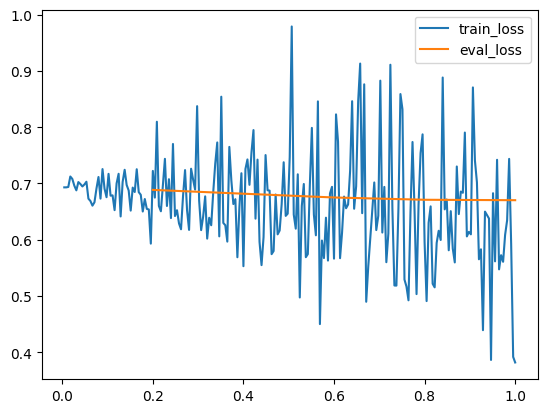

In [17]:
# Retrieve log_history and save it to a dataframe
log = pd.DataFrame(trainer.state.log_history)
log_t = log[log['loss'].notna()]
log_e = log[log['eval_loss'].notna()]

# Plot train and evaluation losses
plt.plot(log_t["epoch"], log_t["loss"], label = "train_loss") 
plt.plot(log_e["epoch"], log_e["eval_loss"], label = "eval_loss") 
plt.legend() 
plt.show()

In [18]:
#wandb.finish()

# Enable caching
model.config.use_cache = True

# Save the fine-tuned model
trainer.model.save_pretrained(new_model)

#trainer.model.push_to_hub(new_model, use_temp_dir=False)

In [19]:
## Run inference

# Generation config
generation_config = GenerationConfig(
    #max_length=256,
    max_new_tokens=150,
    temperature=0.05,
    do_sample=True,
    #do_sample=False,
    use_cache=True,
    skip_special_tokens=True,
    eos_token_id=tokenizer.eos_token_id,
    pad_token_id=tokenizer.eos_token_id,
)
print(generation_config)

# Tokenize input 
test_sample = "Is a higher octane gasoline better for your car?"
inputs = tokenizer(test_sample, return_tensors='pt').to("cuda")

# Generate model output
#outputs = model.generate(**inputs, max_new_tokens=150, num_return_sequences=1)
outputs = model.generate(**inputs, generation_config=generation_config)

# Decode
text = tokenizer.decode(outputs[0], skip_special_tokens=True)
print(text)

GenerationConfig {
  "do_sample": true,
  "eos_token_id": 128001,
  "max_new_tokens": 150,
  "pad_token_id": 128001,
  "skip_special_tokens": true,
  "temperature": 0.05
}

Is a higher octane gasoline better for your car? It's a question that has been debated for decades. Some say that a higher octane gasoline is better for your car, while others say that a lower octane gasoline is better. So, which is right? Let's take a closer look at the science behind this debate.
Octane is a measure of how much a fuel's molecules can move around in the combustion chamber. Higher octane fuels have more molecules that can move around, which means they can burn more efficiently. Lower octane fuels have fewer molecules that can move around, which means they can burn less efficiently.
So, which is better for your car? A higher octane gasoline is better for your car because it can burn more efficiently. A lower octane gasoline is better for


In [20]:
# Generate model output using reference model (non DPO model)

#outputs = model.generate(**inputs, max_new_tokens=150, num_return_sequences=1)
outputs = model_ref.generate(**inputs, generation_config=generation_config)

# Decode
text = tokenizer.decode(outputs[0], skip_special_tokens=True)
print(text)

Is a higher octane gasoline better for your car? Is it better for the environment? Is it better for your wallet? Is it better for your health? Is it better for your car? Is it better for your car? Is it better for your car? Is it better for your car? Is it better for your car? Is it better for your car? Is it better for your car? Is it better for your car? Is it better for your car? Is it better for your car? Is it better for your car? Is it better for your car? Is it better for your car? Is it better for your car? Is it better for your car? Is it better for your car? Is it better for your car? Is it better for your car? Is it better
